# Supervised learning

To test the learning process of the actor architecture (that is more complicated than the one of the critic), we can generate a dataset of states of the minigame (e.g. MoveToBeacon) and associate to each state one of the optimal actions that the agent should learn.

More in particular, since we already know that the agent is able to select the right action (usually move screen), but not the parameters (where to click), the best thing to to would be to use the Mean Square Error loss between the probabilities from which to sample an action and the optimal probability distribution (assuming equal probability for all optimal choices for example). Since we need to click on the position of the screen where the beacon is (and that's a 3x3 spot in a 16x16 grid), the whole procedure could be very easy if we hadn't to process the whole state for choosing an action: in fact a simple identity from the input layer representing the beacon to the output would be optimal (after that there is a softmax for normalization)!   

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

## Create dataset

In [26]:
beacon_x, player_x = np.random.choice(14, size=2) + 1 
beacon_y, player_y = np.random.choice(14, size=2) + 1

state = np.zeros((3,16,16)).astype('float')

beacon_layer = np.zeros((16,16))
xs = [beacon_x-1, beacon_x, beacon_x + 1]
ys = [beacon_x-1, beacon_x, beacon_x + 1]
for x in xs:
    for y in ys:
        beacon_layer[x, y] = 1.
        
player_layer = np.zeros((16,16))
player_layer[player_x, player_y] = 1.

# suppose it's always selected, to mimic real input state 
selected_layer = np.zeros((16,16))
selected_layer[player_x, player_y] = 1.

state[0] = beacon_layer
state[1] = player_layer
state[2] = selected_layer

## select optimal action distribution ##
action_target_distr = beacon_layer/beacon_layer.sum()

In [27]:
print("beacon pos; ", beacon_x, beacon_y)
print("beacon layer: \n", beacon_layer)
print("state; \n", state)
print("optimal action distribution: \n", action_target_distr)

beacon pos;  10 1
beacon layer: 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
state; 
 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [33]:
def generate_state():
    # sample in (1,14), leave out borders
    beacon_x, player_x = np.random.choice(14, size=2) + 1 
    beacon_y, player_y = np.random.choice(14, size=2) + 1
    
    state = np.zeros((3,16,16)).astype(float)
    beacon_layer = np.zeros((16,16))
    xs = [beacon_x-1, beacon_x, beacon_x + 1]
    ys = [beacon_x-1, beacon_x, beacon_x + 1]
    for x in xs:
        for y in ys:
            beacon_layer[x, y] = 1.

    player_layer = np.zeros((16,16))
    player_layer[player_x, player_y] = 1.

    # suppose it's always selected, to mimic real input state 
    selected_layer = np.zeros((16,16))
    selected_layer[player_x, player_y] = 1.

    state[0] = beacon_layer
    state[1] = player_layer
    state[2] = selected_layer

    ## select optimal action distribution ##
    action_target_distr = beacon_layer/beacon_layer.sum()
    
    return state, action_target_distr

In [34]:
def create_action_state_set(size = 10000):
    state_memory = []
    action_memory = []
    
    for i in range(size):
        state, action = generate_state()
        state_memory.append(state)
        action_memory.append(action)
        
    return np.array(state_memory), np.array(action_memory)

In [35]:
%%time
state_set, action_set = create_action_state_set()

CPU times: user 614 ms, sys: 19.7 ms, total: 634 ms
Wall time: 632 ms


In [36]:
state_set.shape

(10000, 3, 16, 16)

In [37]:
action_set.shape

(10000, 16, 16)

In [74]:
from torch.utils.data import DataLoader, Dataset, TensorDataset, SubsetRandomSampler

In [75]:
class NumpyDataset(Dataset):
    """
    Add description
    """
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return (self.data[index], self.label[index])

In [76]:
def prepare_dataset(x, label, train_perc, val_perc, train_batch_size, val_batch_size, test_batch_size):
    """
    Add description
    """
    
    # training/test splitting
    m = int(len(x)*train_perc)
    x_train= x[:m]
    y_train = label[:m]
    x_test =  x[m:]
    y_test = label[m:]
    
    # define custom NumpyDatasets
    train_set = NumpyDataset(x_train, y_train)
    test_set =  NumpyDataset(x_test, y_test)
   
    train_len = int(m*(1-val_perc))
    train_sampler = SubsetRandomSampler(np.arange(train_len))
    val_sampler = SubsetRandomSampler(np.arange(train_len,m))

    train_loader = DataLoader(train_set, train_batch_size, sampler=train_sampler, drop_last=True, collate_fn=lambda x: x)
    val_loader = DataLoader(train_set, val_batch_size, sampler=val_sampler, drop_last=True, collate_fn=lambda x: x)
    test_loader = DataLoader(test_set, test_batch_size, drop_last=False, collate_fn=lambda x: x)

    return train_loader, val_loader, test_loader

In [77]:
batch_size = {'train_batch_size':64, 'val_batch_size':64, 'test_batch_size':128}
train_loader, val_loader, test_loader = prepare_dataset(state_set, action_set, 0.8, 0.2, **batch_size)

## Define agents

Here we suppose that the actor always chooses the _MOVE_SCREEN action and we only train the network to learn the correct distribution of the spatial parameters.

I consider 2 different networks, one that loses the spatial dimension of the input and has to recreate it (Agent 3) and one that keeps that spatial dimension intact.

In [38]:
import torch.nn as nn
import torch.nn.functional as F

In [48]:
class ResidualConvolutional(nn.Module):
    
    def __init__(self, linear_size, n_channels, hidden_channels=12, kernel_size=3):
        super(ResidualConvolutional, self).__init__()
        
        padding = (kernel_size - 1) // 2
        assert (kernel_size - 1) % 2 == 0, 'Provide odd kernel size to use this layer'
        
        self.net = nn.Sequential(
                                nn.LayerNorm((linear_size, linear_size)),
                                nn.Conv2d(n_channels, hidden_channels, kernel_size, stride=1, padding=padding),
                                nn.ReLU(),
                                nn.Conv2d(hidden_channels, n_channels, kernel_size, stride=1, padding=padding)
                                )
        
    def forward(self, x):
        out = self.net(x)
        out = out + x
        return out

In [54]:
linear_size = 16
n_channels = 3
hidden_channels = 12
kernel_size = 5

res_conv = ResidualConvolutional(linear_size, n_channels, hidden_channels, kernel_size)
x = torch.rand(1,k_in,linear_size,linear_size)
y = res_conv(x)

y.shape

torch.Size([1, 3, 16, 16])

In [91]:
class SpatialNet(nn.Module):
    def __init__(self, n_layers, linear_size, in_channels, n_channels, **HPs):
        super(SpatialNet, self).__init__()
        
        self.linear_size = linear_size
        
        layers =  nn.ModuleList([ResidualConvolutional(linear_size, n_channels, **HPs) for _ in range(n_layers-1)])
        
        self.net = nn.Sequential(
                                nn.Conv2d(in_channels, n_channels, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                *layers,
                                nn.ReLU(),
                                nn.Conv2d(n_channels, 1, kernel_size=3, stride=1, padding=1)
                                )
        
    def forward(self, x):
        x = self.net(x)
        x = x.reshape((x.shape[0],-1))
        x = F.softmax(x, dim=-1)
        x = x.reshape((x.shape[0], self.linear_size, self.linear_size))
        return x.squeeze()

In [92]:
n_layers = 2
linear_size = 16
in_channels = 3
n_channels = 12

spatial_net = SpatialNet(n_layers, linear_size, in_channels, n_channels)

In [93]:
x = torch.rand(5, in_channels, linear_size, linear_size)
y = spatial_net(x)
print(y.shape)
y.sum()

torch.Size([5, 16, 16])


tensor(5.0000, grad_fn=<SumBackward0>)

## Train agent

In [94]:
import torch.nn as nn
import torch.optim as optim
import time

In [108]:
### Testing function
def test_epoch(net, dataloader, loss_fn, optimizer):

    # select device
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
        
    # Validation
    net.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # No need to track the gradients
        batch_len = np.zeros(len(dataloader))
        batch_loss = np.zeros(len(dataloader))
        for i, data in enumerate(dataloader,0):
            # Extract data and move tensors to the selected device
            x = [x[0] for x in data]
            x = torch.tensor(x).float().to(device)
            
            y =  [x[1] for x in data]
            y = torch.tensor(y).float().to(device)

            y_pred = net(x)

            loss = loss_fn(y_pred, y)
            
            # save MSE loss and length of a batch
            batch_len[i] = len(data)
            batch_loss[i] = loss.item()
    
    # total loss
    val_loss = (batch_loss*batch_len).sum()/batch_len.sum()
    return val_loss

In [109]:
def train_NN(net, lr, n_epochs, train_loader, val_loader, train_log=True, verbose=True, 
                  debug=False, return_model = False):
    """
    Trains a Pytorch model.
    
    Parameters
    ----------
    model: Pytorch nn.Module class 
        Must have forward method
    train_loader: torch DataLoader
        Loads the training set
    val_loader: torch DataLoader
        Loads the validation set
    verbose: bool
        If True prints updates of the training 10 times for each epoch
    return_model: bool
        If True returns the trained instance of the model 
    **params: dictionary 
        Must contain all the parameters needed by the model, the optimizer and the loss
    
    Returns
    -------
    net (if return_model): Pytorch nn.Module class
        Trained instance of the model 
    train_loss_log (if train_log): list
        Training loss for each epoch
    val_loss_log (if train_log): list
        Validation loss for each epoch
    val_acc_log (if train_log): list
        Validation accuracy for each epoch
    
    """
  
    optimizer = optim.Adamax(net.parameters(), lr)
    loss_fn = nn.MSELoss()
    
    # define contextual print functions activated by print flags
    verbose_print = print if verbose else lambda *a, **k: None
    verbose_print("Verbose: ", verbose)
    dprint = print if debug else lambda *a, **k: None
    dprint("Debug: ", debug)

    # If cuda is available set the device to GPU
    verbose_print("Using cuda: ", torch.cuda.is_available())
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    # Move all the network parameters to the selected device (if they are already on that device nothing happens)
    net.to(device)
    
    n_batches = len(train_loader)
    epoch_time = []
    #Time for printing
    training_start_time = time.time()
    # lists with the history of the training
    if (train_log == True):
        train_loss_log = []
        val_loss_log = []

    #Loop for n_epochs
    for epoch in range(n_epochs):

        running_loss = 0.0
        print_every = n_batches // 10 # frequency of printing
        start_time = time.time()
        total_train_loss = 0
        batches_done = 0
        net.train() # activate dropout
        for i, data in enumerate(train_loader, 0):
            batches_done += 1
            optimizer.zero_grad()
            
            x = [x[0] for x in data]
            x = torch.tensor(x).float().to(device)
            
            y =  [x[1] for x in data]
            y = torch.tensor(y).float().to(device)

            y_pred = net(x)

            loss = loss_fn(y_pred, y)
            # Backward pass
            loss.backward()
            optimizer.step()

            #Print statistics
            running_loss += loss.item() 
            total_train_loss += loss.item()
            #Print every 10th batch of an epoch
            if ((i+1) % (print_every) == 0) or (i == n_batches - 1):
                verbose_print('\r'+"Epoch {}, {:d}% \t Train loss: {:.4f} took: {:.2f}s ".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / batches_done,
                        time.time() - start_time), end=' ')
                
        epoch_time.append(time.time() - start_time)
        if (train_log == True):
            train_loss_log.append(total_train_loss/len(train_loader))
        
        
        #At the end of the epoch, do a pass on the validation set
        val_loss = test_epoch(net, dataloader=val_loader, loss_fn=loss_fn, optimizer=optimizer) 
        if (train_log == True):
            val_loss_log.append(val_loss)
            verbose_print("Val. loss: {:.4f}".format(val_loss ))

    verbose_print("Training finished, took {:.2f}s".format(time.time() - training_start_time))
    if train_log:
        if return_model:
            return net, train_loss_log, val_loss_log#, val_acc_log
        else:
            return train_loss_log, val_loss_log#, val_acc_log  #used during cross validation

In [112]:
lr = 5e-4
n_epochs = 5

n_layers = 2
linear_size = 16
in_channels = 3
n_channels = 12

spatial_net = SpatialNet(n_layers, linear_size, in_channels, n_channels)

In [113]:
trained_spatial_net, spatial_train_loss, spatial_val_loss = train_NN(spatial_net, lr, n_epochs, train_loader, 
                                                                     val_loader, return_model=True)

Verbose:  True
Using cuda:  True
Epoch 1, 100% 	 Train loss: 0.0002 took: 1.72s  Val. loss: 0.0000
Epoch 2, 100% 	 Train loss: 0.0000 took: 1.34s  Val. loss: 0.0000
Epoch 3, 100% 	 Train loss: 0.0000 took: 1.28s  Val. loss: 0.0000
Epoch 4, 100% 	 Train loss: 0.0000 took: 1.56s  Val. loss: 0.0000
Epoch 5, 100% 	 Train loss: 0.0000 took: 1.33s  Val. loss: 0.0000
Training finished, took 8.38s


In [125]:
state, _ = generate_state()
x = torch.tensor(state).float().unsqueeze(0).to('cuda')
probs = spatial_net(x)

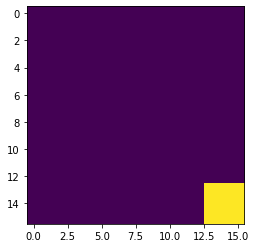

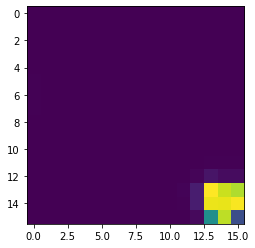

In [126]:
plt.imshow(state[0])
plt.show()
plt.imshow(probs.cpu().detach().numpy())
plt.show()

The objective is so simple that is learned almost immediately in a spatial net with residual connections. Actually as I said above a single linear layer would be enough.